### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## what to plot

- MLD, by latitude
- SST, by latitude
- SOS, by latitude

- Cflx, by latitude
- pco2, by latitude

- Maximum overturning in sigma coordinates, SO
- maximum overturning in regular coordinates, AMOC?

## extract MLD, SST, TOS

In [4]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

mask_latbands = np.copy(maskno)

mask_latbands[maskno == 0.5] = 1
mask_latbands[(maskno == 1) | (maskno == 2.4)] = 2
mask_latbands[(maskno == 1.2) | (maskno == 2.6)] = 3
mask_latbands[(maskno == 1.4) | (maskno == 2.8) | (maskno == 3.6)] = 4
mask_latbands[(maskno == 1.6) | (maskno == 3.0) | (maskno == 3.8)] = 5
mask_latbands[(maskno == 1.8) | (maskno == 3.2) | (maskno == 4.0)] = 6

#####
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([31,149,182])
for i in range(0,31):
    csize_broad[i,:,:] = tmesh['csize'].values
cvol = csize_broad * tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]

cdepth = tmesh['e3t_0'][0,:,:,:] * tmesh['tmask'][0,:,:,:]
cdepth_broad = np.zeros([12,31,149,182])
for i in range(0,12):
    cdepth_broad[i,:,:,:] = cdepth
    
def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/afm/greenocean/software/runs'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        
        t2 = glob.glob(ty)
        print(t2)
        ylist.append(t2[0])
    return ylist

def gimme_var(ds, var):
    '''
    takes ds of type grid, calculates seasonal by-lat 1-d tracers (tos, sos, lmdr10_1.
    '''
    seas_lat_var = np.zeros([12,6]) #storage array
    #print(ds[plant].long_name)
    tmn = ds[var] #.groupby('time_counter.season').mean('time_counter') #get seasonal mean1
    tmesh['csize'] = tmesh.tmask[0,0,:,:] #* tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tmn_molm2 = tmn*tmesh.csize #just 0,1
    #tmn_molm2 = np.nansum(tmn_test, axis = 1) #integrate, ie sum

    for s in range(0,12):        
        for b in range(0,6):
            tmn_molm2_formask = np.copy(tmn_molm2) #copy for manipulations
            tmn_molm2_formask_tseas = tmn_molm2_formask[s,:,:] # 
            tmn_molm2_formask_tseas[mask_latbands != b+1] = 0
            csize_formask = np.copy(csize_broad[0,:,:])
            csize_formask[mask_latbands != b+1] = 0
            seas_lat_var[s,b] = np.ma.average(tmn_molm2_formask_tseas[:,:], weights=csize_formask)

    return seas_lat_var

def make_tracer_seas_lat_gridT(yrst, tr, baseDir = '/gpfs/afm/greenocean/software/runs/'):
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracted/'
    tnam1 = f'{tr}-gridT-{yrst}.nc'
    tnam = f'{tdir}{tr}-gridT-{yrst}.nc'
    print(tnam1)
    
    dtype = 'grid_T'
    #baseDir = '/gpfs/afm/greenocean/software/runs/'
    yrend = yrst #
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    print(ylist)
    ds = xr.open_dataset(ylist[0])
    
    times = pd.date_range(f"{yrst}/01/01",f"{yrst+1}/01/01",freq='MS',closed='left')

    seas_lat_tos = gimme_var(ds, 'tos')
    seas_lat_sos = gimme_var(ds, 'sos')
    seas_lat_mldr10_1 = gimme_var(ds, 'mldr10_1')
    
    data_vars = {
#                     'Alkalini':(['time_counter',  'lat_band'], seas_lat_Alkalini,
#                  {'units': 'mol/m2'}),
                     
                 'sos':(['time_counter',  'lat_band'], seas_lat_sos,
                 {'units': 'g/kg'}),
                 'tos':(['time_counter',  'lat_band'], seas_lat_tos,
                 {'units': 'degC'}),
                 'mldr10_1':(['time_counter',  'lat_band'], seas_lat_mldr10_1,
                 {'units': 'm'}),        

                }

    # define coordinates
    coords = {'time_counter': (['time_counter'], times),\
             'lat_band': (['lat_band'], np.arange(1,7,1)),}

    # define global attributes
    attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracter-mld-sst-tos.ipynb',
             'latitude bands': 'see notebook, 1 is arctic, 6 is SO',
            }
    
#     # create dataset
    ds2 = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)
    
    ds2.to_netcdf(f'{tnam}')
    


### extract cflx and pco2, PPINT

In [5]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_GEA3/ORCA2_1m_19400101_19401231_diad_T.nc')
w.PPINT

<xarray.DataArray 'PPINT' (time_counter: 12, y: 149, x: 182)>
[325416 values with dtype=float32]
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
    time_centered  (time_counter) object ...
  * time_counter   (time_counter) object 1940-01-16 12:00:00 ... 1940-12-16 1...
Dimensions without coordinates: y, x
Attributes:
    long_name:           
    units:               mol/m2/s
    online_operation:    average
    interval_operation:  5760 s
    interval_write:      1 month
    cell_methods:        time: mean (interval: 5760 s)

In [6]:
def gimme_var_lev(ds, var, lev = 0):
    '''
    takes ds of type grid, calculates seasonal by-lat 1-d tracers (tos, sos, lmdr10_1.
    '''
    seas_lat_var = np.zeros([12,6]) #storage array
    #print(ds[plant].long_name)
    tmn = ds[var][:,lev,:,:] #.groupby('time_counter.season').mean('time_counter') #get seasonal mean1
    tmesh['csize'] = tmesh.tmask[0,0,:,:] #* tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    tmn_molm2 = tmn*tmesh.csize #just 0,1
    #tmn_molm2 = np.nansum(tmn_test, axis = 1) #integrate, ie sum

    for s in range(0,12):        
        for b in range(0,6):
            tmn_molm2_formask = np.copy(tmn_molm2) #copy for manipulations
            tmn_molm2_formask_tseas = tmn_molm2_formask[s,:,:] # 
            tmn_molm2_formask_tseas[mask_latbands != b+1] = 0
            csize_formask = np.copy(csize_broad[0,:,:])
            csize_formask[mask_latbands != b+1] = 0
            seas_lat_var[s,b] = np.ma.average(tmn_molm2_formask_tseas[:,:], weights=csize_formask)

    return seas_lat_var

def make_tracer_seas_lat_diadT(yrst, tr, baseDir = '/gpfs/afm/greenocean/software/runs/'):
    
    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracted/'
    tnam1 = f'{tr}-diadT-{yrst}.nc'
    tnam = f'{tdir}{tr}-diadT-{yrst}.nc'
    print(tnam1)
    
    dtype = 'diad_T'
    #baseDir = '/gpfs/afm/greenocean/software/runs/'
    yrend = yrst #
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    print(ylist)

    ds = xr.open_dataset(ylist[0])
    
    times = pd.date_range(f"{yrst}/01/01",f"{yrst+1}/01/01",freq='MS',closed='left')

    seas_lat_tos = gimme_var(ds, 'Cflx')
    seas_lat_sos = gimme_var(ds, 'pCO2')
    seas_lat_mldr10_1 = gimme_var(ds, 'PPINT')
    seas_lat_EXP = gimme_var_lev(ds,'EXP',10)
 
    dtype = 'ptrc_T'
    #baseDir = '/gpfs/afm/greenocean/software/runs/'
    yrend = yrst #
    ylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)
    ds = xr.open_dataset(ylist[0])
    
    times = pd.date_range(f"{yrst}/01/01",f"{yrst+1}/01/01",freq='MS',closed='left')

    seas_lat_DIC = gimme_var_lev(ds, 'DIC')
    seas_lat_Alkalini = gimme_var_lev(ds, 'Alkalini')

    
    data_vars = {
#                     'Alkalini':(['time_counter',  'lat_band'], seas_lat_Alkalini,
#                  {'units': 'mol/m2'}),
                     
                 'pCO2':(['time_counter',  'lat_band'], seas_lat_sos,
                 {'units': 'uatm'}),
                 'Cflx':(['time_counter',  'lat_band'], seas_lat_tos,
                 {'units': 'mol/m2/s'}),
                 'PPINT':(['time_counter',  'lat_band'], seas_lat_mldr10_1,
                 {'units': 'mol/m2/s'}),       
                 'EXP105m':(['time_counter',  'lat_band'], seas_lat_EXP,
                 {'units': 'mol/m2/s'}), 
                 'surfDIC':(['time_counter',  'lat_band'], seas_lat_DIC,
                 {'units': 'mol/m3'}), 
                 'surfTA':(['time_counter',  'lat_band'], seas_lat_Alkalini,
                 {'units': 'mol/m3'}),         
                }

    # define coordinates
    coords = {'time_counter': (['time_counter'], times),\
             'lat_band': (['lat_band'], np.arange(1,7,1)),}

    # define global attributes
    attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracter-mld-sst-tos.ipynb',
             'latitude bands': 'see notebook, 1 is arctic, 6 is SO',
            }
    
#     # create dataset
    ds2 = xr.Dataset(data_vars=data_vars,
                    coords=coords,
                    attrs=attrs)
    
    ds2.to_netcdf(f'{tnam}')





In [7]:
extract = True

if extract:
        
    for i in range(1948,2022):
#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GNA2')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GNA2')

#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GEA3')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GEA3')

#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GEC2')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GEC2')

#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GNC2')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GNC2')
        
#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GNCB')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GNCB')

#         make_tracer_seas_lat_diadT(i, 'TOM12_DW_GA01')
#         make_tracer_seas_lat_gridT(i, 'TOM12_DW_GA01')
        
#         make_tracer_seas_lat_diadT(i, 'TOM12_DW_GC01')
#         make_tracer_seas_lat_gridT(i, 'TOM12_DW_GC01')

#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_RVA0')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_RVA0')
        
#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_RVC0')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_RVC0')

        make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GNAP')
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GNAP')

TOM12_TJ_GNAP-diadT-1948.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19480101_19481231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19480101_19481231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19480101_19481231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1948.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19480101_19481231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19480101_19481231_grid_T.nc']
TOM12_TJ_GNAP-diadT-1949.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19490101_19491231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19490101_19491231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19490101_19491231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1949.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19490101_19491231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19490101

['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19640101_19641231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1964.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19640101_19641231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19640101_19641231_grid_T.nc']
TOM12_TJ_GNAP-diadT-1965.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19650101_19651231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19650101_19651231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19650101_19651231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1965.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19650101_19651231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19650101_19651231_grid_T.nc']
TOM12_TJ_GNAP-diadT-1966.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19660101_19661231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19660101

TOM12_TJ_GNAP-gridT-1980.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19800101_19801231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19800101_19801231_grid_T.nc']
TOM12_TJ_GNAP-diadT-1981.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19810101_19811231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19810101_19811231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19810101_19811231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1981.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19810101_19811231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19810101_19811231_grid_T.nc']
TOM12_TJ_GNAP-diadT-1982.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19820101_19821231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19820101_19821231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19820101

TOM12_TJ_GNAP-diadT-1997.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19970101_19971231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19970101_19971231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19970101_19971231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1997.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19970101_19971231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19970101_19971231_grid_T.nc']
TOM12_TJ_GNAP-diadT-1998.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19980101_19981231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19980101_19981231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19980101_19981231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-1998.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19980101_19981231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_19980101

['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20130101_20131231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-2013.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20130101_20131231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20130101_20131231_grid_T.nc']
TOM12_TJ_GNAP-diadT-2014.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20140101_20141231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20140101_20141231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20140101_20141231_ptrc_T.nc']
TOM12_TJ_GNAP-gridT-2014.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20140101_20141231_grid_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20140101_20141231_grid_T.nc']
TOM12_TJ_GNAP-diadT-2015.nc
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20150101_20151231_diad_T.nc']
['/gpfs/afm/greenocean/software/runs//TOM12_TJ_GNAP/ORCA2_1m_20150101

In [8]:
w = xr.open_dataset('./extracted/TOM12_TJ_GNC2-diadT-1940.nc')
w

<xarray.Dataset>
Dimensions:       (lat_band: 6, time_counter: 12)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1940-01-01 ... 1940-12-01
  * lat_band      (lat_band) int64 1 2 3 4 5 6
Data variables:
    pCO2          (time_counter, lat_band) float64 ...
    Cflx          (time_counter, lat_band) float64 ...
    PPINT         (time_counter, lat_band) float64 ...
    EXP105m       (time_counter, lat_band) float64 ...
    surfDIC       (time_counter, lat_band) float64 ...
    surfTA        (time_counter, lat_band) float64 ...
Attributes:
    made in:         SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparis...
    latitude bands:  see notebook, 1 is arctic, 6 is SO

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


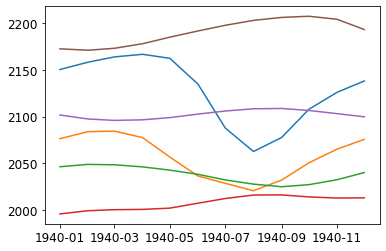

In [9]:
plt.figure()

for i in range(0,6):
    plt.plot(w.time_counter,w.surfDIC[:,i]*1e6)

## overturning - sigma and depth coords

In [10]:
# sys.path.append('/gpfs/home/mep22dku/scratch/NEMO-related/')
# from pyCDFTOOLS.cdfmocsig import *
# from pyCDFTOOLS.cdfmoc import *


In [11]:
def make_ncsig(name, times, latV, sigma2000, dmoc2000):

    data_vars = {
                 'dmoc2000':(['time_counter', 'sigma2000', 'latV'], dmoc2000,
    {'units': 'Sv',
    'long_name':'sigma-coordinates overturning, ref pressure 2000 dbar'}),
    }

    coords = {'time_counter': (['time_counter'], times),
    'latV': (['latV'],latV),
    'sigma2000': (['sigma2000'], sigma2000),
             }

    attrs = {'made in':\
             'SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracter-mld-sst-tos.ipynb',
    'desc': 'concatenate monthly overturning output into yearly and give good dates for later processing'
    }
    savenam = name
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)
    
    return 

def wrap_cdfmocsig(yr, tdir, tsig = 2000, **kwargs):
    
    fileV = f'ORCA2_1m_{yr}0101_{yr}1231_grid_V.nc'
    fileT = f'ORCA2_1m_{yr}0101_{yr}1231_grid_T.nc'
    bins = sigma_bins(tsig)
    # print(bins)#use the 2000 version. maybe look at where the sigma 
    data_dir = f'/gpfs/data/greenocean/software/runs/{tdir}/'
    # for putting extra options in
    #   -- kt       = number for using a specified time entry (python indexing)
    #   -- kz       = number for using a specified vertical level/layer (python indexing)
    #   -- lprint   = True   for printing out variable names in netcdf file
    #   -- lverb    = True   for printing out more information
    #   -- lg_vvl   = True   for using s-coord (time-varying metric)
    #   -- ldec     = True   decompose the MOC into some components
    #   -- leiv     = True   for adding the eddy induced velocity component
    #        eivv_var = string for EIV-v variable name
    #   -- lisodep  = True   (not yet implemented) output zonal averaged isopycnal depth
    #   -- lntr     = True   (not yet implemented) do binning with neutral density


    # generate a field
    sigma, depi, latV, dmoc, opt_dic = cdfmocsig(data_dir, fileV, "vomecrty", fileT, "votemper", "vosaline", bins, **kwargs)
    
    return sigma, depi, latV, dmoc, opt_dic

#sigma, depi, latV, dmoc, opt_dic = wrap_cdfmocsig(1950, 'TOM12_TJ_1AA6', **kwargs)

def get_sigmaOT_TOM(year, run, \
                    tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracted/'):

    w = time.time()
    tdir = './extracted/'
    name1 = f'{run}_{year}_mocsig.nc'
    name = f'{tdir}{name1}'
    print(name)
    
    dmoc_stor = np.zeros([12, 158, 149])
    times = pd.date_range(f"{year}/01/01",f"{year+1}/01/01",freq='MS',closed='left')

    
    for i in range(0,12):

        kwargs =  {"kt"     : i,
                   "lprint" : False,
                   "lg_vvl" : False,
                   "ldec"   : False,
                   "leiv"   : False,  "eivv_var" : "voce_eiv",
                   "lisodep": False,
                   "lntr"   : False,
                   "lverb"  : True}
        
        sigma, depi, latV, dmoc, opt_dic = wrap_cdfmocsig(year, run, **kwargs)
        dmoc_stor[i,:,:] = dmoc

    make_ncsig(name, times, latV, sigma, dmoc_stor)
    
    w2 = time.time()
    print(w2-w)
    
    return



In [12]:
def make_nc(name, times, latV, gdepw, dmoc_stor):

    data_vars = {
                 'moc':(['time_counter', 'gdepw', 'latV'], dmoc_stor,
    {'units': 'Sv',
    'long_name':'depth-coordinates overturning'}),
    }

    coords = {'time_counter': (['time_counter'], times),
    'latV': (['latV'],latV),
    'gdepw': (['gdepw'], gdepw),
             }

    attrs = {'made in':\
             'SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracter-mld-sst-tos.ipynb',
    'desc': 'concatenate monthly overturning output into yearly and give good dates for later processing'
    }
    savenam = name
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(savenam)
    
    return 

def wrap_cdfmoc(yr, tdir, **kwargs):
    
    fileV = f'ORCA2_1m_{yr}0101_{yr}1231_grid_V.nc'

    data_dir = f'/gpfs/data/greenocean/software/runs/{tdir}/'
    
    gdepw, rdumlat, dmoc, opt_dic = cdfmoc(data_dir, fileV, "vomecrty", **kwargs)    
    return gdepw, rdumlat, dmoc, opt_dic

def get_OT_TOM(year, run, \
               tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracted/'):

    w = time.time()
    name1 = f'{run}_{year}_moc.nc'
    name = f'{tdir}{name1}'
    print(name)
    
    dmoc_stor = np.zeros([12, 31, 149])
    times = pd.date_range(f"{year}/01/01",f"{year+1}/01/01",freq='MS',closed='left')

    
    for i in range(0,12):

        kwargs = {"kt"     : i,
                 "lprint" : False,
                 "lg_vvl" : False,
                 "ldec"   : False,
                 "lbas"   : False,
                 "leiv"   : False}
        
        gdepw, rdumlat, dmoc, opt_dic = wrap_cdfmoc(year, run, **kwargs)
        dmoc_stor[i,:,:] = dmoc

    make_nc(name, times, rdumlat, gdepw, dmoc_stor)
    
    w2 = time.time()
    print(w2-w)
    
    return

In [13]:
sys.path.append('/gpfs/home/mep22dku/scratch/NEMO-related/')
from pyCDFTOOLS.cdfmocsig import *
from pyCDFTOOLS.cdfmoc import *

get_sigmaOT_TOM(1940,'TOM12_TJ_GNA2')
get_OT_TOM(1940,'TOM12_TJ_GNA2')


extract = False
if extract:

    for i in range(1940,2016):
        get_sigmaOT_TOM(i,'TOM12_TJ_GEA3')
        get_OT_TOM(i,'TOM12_TJ_GEA3')
#     for i in range(1940,2016):
#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GEA3')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GEA3')
        
#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GEC2')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GEC2')
        
    for i in range(1941,1942):
        make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GNA2')
        make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GNA2')
        
        
#     for i in range(1940,1978):

#         make_tracer_seas_lat_diadT(i, 'TOM12_TJ_GNC2')
#         make_tracer_seas_lat_gridT(i, 'TOM12_TJ_GNC2')


./extracted/TOM12_TJ_GNA2_1940_mocsig.nc
min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning = 30.025
max density for binning = 37.875
slow k loop, progress = 0.00 %...0.32 %...0.65 %...min density for binning

In [14]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_GNA2/mesh_mask.nc')

w.e3v_0

<xarray.DataArray 'e3v_0' (t: 1, z: 31, y: 149, x: 182)>
[840658 values with dtype=float64]
Dimensions without coordinates: t, z, y, x

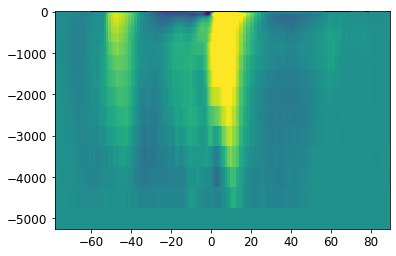

In [15]:
w = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/NCEP-ERA-physics-comparison/extracted/TOM12_TJ_GNA2_1940_moc.nc')

plt.pcolormesh(w.latV,w.gdepw,w.moc[0,:,:], vmin = -40, vmax = 40)

In [16]:
w2 = xr.open_dataset('/gpfs/home/mep22dku/cdftools/moc_TOM12_TJ_GNA2_1940.nc')

In [17]:
tdat = w2.zomsfglo[0,:,:,0].values
print(np.shape(tdat))
tdat2 = (w.moc[0,:,:].values)

# tdat[tdat>100] = np.nan
# tdat2[tdat2>100] = np.nan
# tdat[tdat<-100] = np.nan
# tdat2[tdat2<-100] = np.nan
# print(np.shape(tdat2))

tdiff = tdat - tdat2

(31, 149)


18192415.72906976
(2, 90)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 126
 127 128 129 130 131 132 135 136 137 138 139 140 141 142 143 144 145 147]


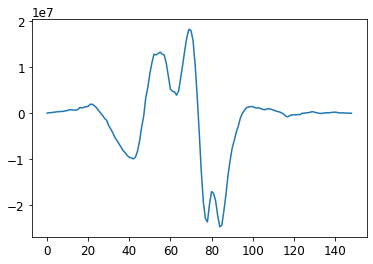

In [18]:
print(np.nanmax(tdat2))


q = (np.where(tdat2>90))
print(np.shape(q))

print(q[0][:])
print(q[1][:])

plt.plot(tdat2[0,:])

In [19]:
tdat = w2.zomsfglo[0,:,:,0].values
print(np.shape(tdat))
tdat2 = (w.moc[0,:,:].values)


(31, 149)


In [20]:
print(np.nanmax(tdat))
print(np.nanmax(tdat2))
print(np.nanmax(tdiff))

print(np.nanmin(tdat))
print(np.nanmin(tdat2))
print(np.nanmin(tdiff))

print(np.nanmean(tdiff))

75.48541
18192415.72906976
24669123.5696878
-39.783714
-24669124.27022405
-18192416.09309988
29339.139730622053


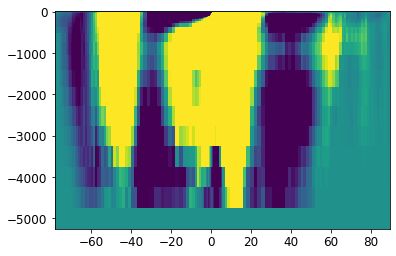

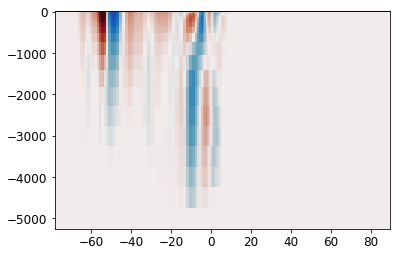

In [21]:
plt.figure()
plt.pcolormesh(w.latV,w2.depthw,w2.zomsfglo[0,:,:,0], vmin = -4, vmax = 4)

plt.figure()
plt.pcolormesh(w.latV,w2.depthw,tdiff, vmin = -10, vmax = 10, cmap = cm.balance)

In [22]:
w2

<xarray.Dataset>
Dimensions:       (depthw: 31, time_counter: 12, x: 1, y: 149)
Coordinates:
  * depthw        (depthw) float32 -0.0 -10.000015 ... -4500.0215 -5000.0
  * time_counter  (time_counter) object 1940-01-16 12:00:00 ... 1940-12-16 12...
Dimensions without coordinates: x, y
Data variables:
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    zomsfglo      (time_counter, depthw, y, x) float32 ...
    zomsfatl      (time_counter, depthw, y, x) float32 ...
    zomsfinp      (time_counter, depthw, y, x) float32 ...
    zomsfind      (time_counter, depthw, y, x) float32 ...
    zomsfpac      (time_counter, depthw, y, x) float32 ...
    zomsfinp0     (time_counter, depthw, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation